In [1]:
!pip install pysurvival
!pip install lifelines
!pip install osqp==0.5
!pip install scikit-survival
!pip install hyperopt
!pip install pycox

     |████████████████████████████████| 4.8MB 12.3MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp37-cp37m-linux_x86_64.whl size=3773055 sha256=cc6a9edbfd1cb1908b1627e0547023cf5831dc5049fcbf5b57efba94487c22e9
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp37-none-any.whl size=12076 sha256=e3e3bce3693415e00caba757d78b432a3ed7225bbead925e2ddedfb5aeecde5b
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 348kB 11.7MB/s 
     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp37-none-any.whl size=4035 sha256=e1dcb5682c3bb6c61cb7f04c45075e1c3109b02453fe2eddde3f2d3b186570c9
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.distributions.weibull import Weibull
from torch.distributions.log_normal import LogNormal
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
import pandas as pd
import numpy as np
import scipy.stats as ss
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from lifelines.utils import concordance_index# as c_index
from sksurv.metrics import brier_score, integrated_brier_score, concordance_index_censored as ci_scikit
from hyperopt import hp
import hyperopt as ho
from copy import copy, deepcopy
import dask
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%pylab inline
from google.colab import files
uploaded = files.upload()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy



Saving CleanCreditCardChurn_2.csv to CleanCreditCardChurn_2.csv


In [3]:
import io 
df = pd.read_csv(io.BytesIO(uploaded['CleanCreditCardChurn_2.csv']))
df

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,0,3,0,0,0,0,39.00001,5,1,3,12691.0,777,1.335,1144,42,1.625,0.061
1,0,49,1,5,1,1,1,0,44.00001,6,1,2,8256.0,864,1.541,1291,33,3.714,0.105
2,0,51,0,3,1,0,2,0,36.00001,4,1,0,3418.0,0,2.594,1887,20,2.333,0.000
3,0,40,1,4,0,2,1,0,34.00001,3,4,1,3313.0,2517,1.405,1171,20,2.333,0.760
4,0,40,0,3,2,0,0,0,21.00001,5,1,0,4716.0,0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,0,2,1,1,3,0,40.00001,3,2,3,4003.0,1851,0.703,15476,117,0.857,0.462
10123,1,41,0,2,3,3,3,0,25.00001,4,2,3,4277.0,2186,0.804,8764,69,0.683,0.511
10124,1,44,1,1,0,0,1,0,36.00001,5,3,4,5409.0,0,0.819,10291,60,0.818,0.000
10125,1,30,0,2,1,2,3,0,36.00001,4,3,3,5281.0,0,0.535,8395,62,0.722,0.000


In [ ]:
df['Months_on_book'].min()

13.000010000000001

In [4]:
time_column = 'Months_on_book'
event_column = 'Attrition_Flag'
categorical = ['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
numerical = ['Gender', 'Customer_Age','Dependent_count','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal','Total_Amt_Chng_Q4_Q1',
             'Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']

In [5]:
from sklearn.model_selection import train_test_split

features = np.setdiff1d(df.columns, [time_column, event_column] ).tolist()
index_train, index_test = train_test_split(range(df.shape[0]), test_size=0.3, random_state=0, stratify=df[event_column])

tmp_data_train = df.loc[index_train].reset_index( drop = True )
data_test  = df.loc[index_test].reset_index( drop = True )

index_train, index_valid = train_test_split(tmp_data_train.index, test_size=0.1, random_state=0, stratify=tmp_data_train[event_column])
data_train = tmp_data_train.loc[index_train].reset_index( drop = True )
data_valid = tmp_data_train.loc[index_valid].reset_index( drop = True )

 
# Creating the X, T and E inputs
X_train, X_valid, X_test = data_train[features], data_valid[features], data_test[features]
T_train, T_valid, T_test = data_train[time_column], data_valid[time_column], data_test[time_column]
E_train, E_valid, E_test = data_train[event_column], data_valid[event_column], data_test[event_column]
 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(X_train[numerical])
scaled_valid = scaler.transform(X_valid[numerical])
scaled_test = scaler.transform(X_test[numerical])
X_train[numerical], X_valid[numerical], X_test[numerical] = scaled_train, scaled_valid, scaled_test

X_train.shape, X_valid.shape, X_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



((6379, 17), (709, 17), (3039, 17))

In [ ]:
t = np.where(E_train==1)[0]
max(T_train.iloc[t])

56.000009999999996

In [8]:
from torch import autograd
 
class CENSORED_SURV_DATA(Dataset):
    def __init__(self, X_cens, T_cens, cont_columns, cat_columns):
        self.X1_cens, self.X2_cens, self.T_cens = X_cens[cont_columns].values.astype(np.float64), X_cens[cat_columns].values, T_cens.values.astype(np.float64)
 
    def __len__(self):
        return len(self.T_cens)
 
    def __getitem__(self, idx):
        return self.X1_cens[idx], self.X2_cens[idx], self.T_cens[idx]
 
class UNCENSORED_SURV_DATA(Dataset):
    def __init__(self, X_uncens, T_uncens, cont_columns, cat_columns):
        self.X1_uncens, self.X2_uncens, self.T_uncens = X_uncens[cont_columns].values.astype(np.float64), X_uncens[cat_columns].values, T_uncens.values.astype(np.float64)
 
    def __len__(self):
        return len(self.T_uncens)
 
    def __getitem__(self, idx):
        return self.X1_uncens[idx], self.X2_uncens[idx], self.T_uncens[idx]

class Embedder(nn.Module):
    def __init__(self, embedding_sizes):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size).double() for categories,size in embedding_sizes])

    def forward(self, x):
        for i,e in enumerate(self.embeddings):
            print(x[:,i], e, self.embeddings)
        x = [e(x[:,i]) for i,e in enumerate(self.embeddings)]
        return torch.cat(x, 1)

class NNModel(nn.Module):
    def __init__(self, input_shape, units=None, factors=None, dropout=None, slops=None):
        super().__init__()
        self.input_shape = input_shape
        self.units = units
        self.factors = factors
        self.network = nn.ModuleList()
        if self.factors:
            self.units = np.round(self.input_shape * np.asarray(self.factors)).astype(int)
        if self.units is not None:
            self.dropout = np.zeros_like(self.units) if dropout is None else dropout
            self.slops = np.full(len(self.units), 1.) if slops is None else slops
            for i, j, k in zip(self.units, self.dropout, self.slops):
                if i >= 1:
                    block = self.__build_block__(input_shape, i, p=j, slop=k)
                    self.network.extend(block)
                    input_shape = i
        self.output_shape = input_shape
        self.reset_parameters()
    
    def __build_block__(self, input_shape, units, p, slop, norm=True):
        block = []
        block.append(nn.Linear(input_shape, units, bias=True).double())
        if norm:
            #block.append(nn.BatchNorm1d(units).double())
            block.append(nn.LayerNorm(units, eps=1e-5).double())
        block.append(nn.ELU(slop))
        if p > 0:
            block.append(nn.Dropout(p))
        return block
 
    def forward(self, x):
        for layer in self.network:
          tmp = layer(x)
          x = tmp
        return x
 
    def reset_parameters(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                layer.bias.data.fill_(0.1)
 
    def get_weight(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                print('MAX WEIGHT = ', layer.weight.max())
                print('MIN WEIGHT = ', layer.weight.min())
 
    def get_grad(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                print('MAX GRAD = ', layer.weight.grad.max())
                print('MIN GRAD = ', layer.weight.grad.min())
 
 
class DenseBlock(nn.Module):
    def __init__(self, input_shape, nb_block, growth_rate, units, factors=None, dropout=0., slops=1.):
        super(DenseBlock, self).__init__()
        self.dropout = [dropout for i in range(nb_block)]
        self.slops = [slops for i in range(nb_block)]
        self.growth_rate = growth_rate
        self.network = nn.ModuleList()
        for j, k, l in zip(self.dropout, self.slops, range(nb_block)):
            block = NNModel(input_shape, units=[units], factors=factors, dropout=[j], slops=[k])
            self.network.extend([block])
            input_shape += units
            units += growth_rate
        self.input_shape = input_shape
        self.output_shape = units
 
    def forward(self, input):
        for block in self.network:
            x = block(input)
            input = torch.cat((input, x), 1)
        return input
 
class DenseNet(nn.Module):
    def __init__(self, input_layer, dense_blocks):
        super(DenseNet, self).__init__()
        self.input_layer = input_layer
        self.network = nn.ModuleList()
        self.network.extend(dense_blocks)
        self.output_shape = dense_blocks[-1].output_shape
 
    def forward(self, input):
        input = self.input_layer(input) if self.input_layer else input
        for i in self.network:
            input = i(input)
        return input
 
 
class MWN(nn.Module):
    def __init__(self, embedder, shared, clf_nn, alpha_nn, beta_nn, n_comp):
        super(MWN, self).__init__()
        self.embedder = embedder
        self.shared = shared
        self.clf_nn = clf_nn
        self.alpha_nn = alpha_nn
        self.beta_nn = beta_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp).double() if self.n_comp > 1 else None
        self.ai = nn.Linear(self.alpha_nn.output_shape, self.n_comp).double()
        self.bi = nn.Linear(self.beta_nn.output_shape, self.n_comp).double()
 
    def forward(self, x_cont, x_cat):
        x = self.embedder(x_cat)
        x = torch.cat([x, x_cont], 1)
        x = self.shared(x)
        #x = torch.cat((x, z), 1)
        proba = self.proba_model(x) if self.n_comp > 1 else torch.ones((len(x),1))
        alpha = self.alpha_model(x)
        beta = self.beta_model(x)
        return proba, beta, alpha
 
    def proba_model(self, x):
        model = self.clf_nn(x)
        model = self.pi(model)
        model = nn.Softmax(dim=-1)(model)
        return model
 
    def alpha_model(self, x):
        model = self.alpha_nn(x)
        model = self.ai(model)
        model = nn.ELU()(model) + 1 + 1e-5 #WEIBULL
        return model
 
    def beta_model(self, x):
        model = self.beta_nn(x)
        model = self.bi(model)
        model = nn.ELU()(model) + 2 #WEIBULL
        #model = nn.ELU()(model) + 1 + 1e-5 #LOGNORMAL
        return model
 
    def get_grad(self):
        self.shared.get_grad()
        self.clf_nn.get_grad()
        self.alpha_nn.get_grad()
        self.beta_nn.get_grad()
        print('MAX GRAD = ', self.pi.weight.grad.max())
        print('MAX GRAD = ', self.ai.weight.grad.max())
        print('MAX GRAD = ', self.bi.weight.grad.max())
 
    def get_weight(self):
        self.shared.get_weight()
        self.clf_nn.get_weight()
        self.alpha_nn.get_weight()
        self.beta_nn.get_weight()
        print('MAX WEIGHT = ', self.pi.weight.max())
        print('MIN WEIGHT = ', self.pi.weight.min())
        print('MAX WEIGHT = ', self.ai.weight.max())
        print('MIN WEIGHT = ', self.ai.weight.min())
        print('MAX WEIGHT = ', self.bi.weight.max())
        print('MIN WEIGHT = ', self.bi.weight.min())
        print('DTYPE = ', self.bi.weight.dtype)


class MLNN(nn.Module):
    def __init__(self, shared, clf_nn, mu_nn, std_nn, n_comp):
        super(MLNN, self).__init__()
        self.shared = shared
        self.clf_nn = clf_nn
        self.mu_nn = mu_nn
        self.std_nn = std_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp).double() if self.n_comp > 1 else None
        self.mu = nn.Linear(self.mu_nn.output_shape, self.n_comp).double()
        self.std = nn.Linear(self.std_nn.output_shape, self.n_comp).double()
 
    def forward(self, x):
        z = self.shared(x)
        x = torch.cat((x, z), 1)
        proba = self.proba_model(x) if self.n_comp > 1 else torch.ones((len(x),1))
        mu = self.mu_model(x)
        std = self.std_model(x)
        return proba, mu, std
 
    def proba_model(self, x):
        model = self.clf_nn(x)
        model = self.pi(model)
        model = nn.Softmax(dim=-1)(model)
        return model
 
    def mu_model(self, x):
        model = self.mu_nn(x)
        model = self.mu(model)
        model = nn.ELU()(model) + 1# + 1e-5
        return model
 
    def std_model(self, x):
        model = self.std_nn(x)
        model = self.std(model)
        model = nn.ELU()(model) + 1 + 1e-5 #LOGNORMAL
        return model
 
class BaseParametric:
    def __init__(self, model, num_time_bins, cont_columns, cat_columns, resume=None):
        self.model = model
        self.cont_columns, self.cat_columns = cont_columns, cat_columns
        self.losses = {'Epoch': [], 'Train': [], 'Test': [], 'State': [], 'LR': []}
        self.num_time_bins = num_time_bins
        self.times = None
        self.optim = resume
 
    def process_data(self, data, time, event):
        uncens_idx = np.where(event==1)[0]
        X_uncens, Y_uncens, T_uncens = data.iloc[uncens_idx, :], event.iloc[uncens_idx], time.iloc[uncens_idx]
        cens_idx = np.where(event==0)[0]
        X_cens, Y_cens, T_cens = data.iloc[cens_idx, :], event.iloc[cens_idx], time.iloc[cens_idx]
        return X_uncens, Y_uncens, T_uncens, X_cens, Y_cens, T_cens
 
 
    def train_model(self, optim, uncens_train_load, cens_train_load, grad_clip, l2_reg):
          total_loss = 0
          self.model = self.model.train()
        #with autograd.detect_anomaly():
          for i, (uncens, cens) in enumerate(zip(uncens_train_load, cens_train_load)):
              #self.model.get_weight()
              X1_uncens, X2_uncens, T_uncens = uncens
              X1_cens, X2_cens, T_cens = cens
              self.optim.zero_grad()
              loss = self.loss_function(X1_uncens, X2_uncens, T_uncens, X1_cens, X2_cens, T_cens, l2_reg)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
              self.optim.step()
              '''self.model.get_grad()
              print('_'*50)'''
              total_loss += loss.item()
          return total_loss/(i+1)#np.abs(-100. - total_loss)#criterion(total_loss/(i+1), torch.tensor([-100]))
        
 
    def eval_model(self, uncens_test_load, cens_test_load):
        self.model = self.model.eval()
        total_loss = 0
        for i, (uncens, cens) in enumerate(zip(uncens_test_load, cens_test_load)):
            X1_uncens, X2_uncens, T_uncens = uncens
            X1_cens, X2_cens, T_cens = cens
            loss = self.loss_function(X1_uncens, X2_uncens, T_uncens, X1_cens, X2_cens, T_cens, l2_reg=0)
            total_loss += loss.item()
        return total_loss/(i+1)#np.abs(-100. - total_loss)
 
    def lr_finder(self, X_train, T_train, E_train, min_lr, max_lr, batch_size=None,  grad_clip=100, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1, 
                  l2_reg=0):
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
 
        batch_size = len(X_train) if batch_size is None else batch_size
        X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        uncens_train_load = DataLoader(UNCENSORED_SURV_DATA(X_train_uncens, T_train_uncens, self.cont_columns, self.cat_columns), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        cens_train_load = DataLoader(CENSORED_SURV_DATA(X_train_cens, T_train_cens, self.cont_columns, self.cat_columns), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        self.optim = opt.SGD(self.model.parameters(), lr=min_lr, momentum=momentum, nesterov=True, weight_decay=l2_reg)
        scheduler = opt.lr_scheduler.StepLR(self.optim, step_size=1, gamma=2)
        lr, loss = [], []
        curr_lr = min_lr
        while curr_lr<max_lr:
            train_loss = self.train_model(self.optim, uncens_train_load, cens_train_load, grad_clip, l2_reg)
            scheduler.step()
            curr_lr = scheduler.get_last_lr()[0]
            lr.append(curr_lr), loss.append(train_loss)
        return lr, loss
 
    def fit(self, X_train, T_train, E_train, epoch, lr, opt_kwarg, batch_size=None,  grad_clip=100, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1,
            X_test=None, T_test=None, E_test=None, l2_reg=0, eval=True, verbose=True, save=True):
        
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
 
        batch_size = len(X_train) if batch_size is None else batch_size
        X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        uncens_train_load = DataLoader(UNCENSORED_SURV_DATA(X_train_uncens, T_train_uncens, self.cont_columns, self.cat_columns), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        cens_train_load = DataLoader(CENSORED_SURV_DATA(X_train_cens, T_train_cens, self.cont_columns, self.cat_columns), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        if X_test is not None:
            X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
            uncens_test_load = DataLoader(UNCENSORED_SURV_DATA(X_test_uncens, T_test_uncens, self.cont_columns, self.cat_columns), batch_size=batch_size, shuffle=True)  # DATALOADER obj
            cens_test_load = DataLoader(CENSORED_SURV_DATA(X_test_cens, T_test_cens, self.cont_columns, self.cat_columns), batch_size=batch_size, shuffle=True)  # DATALOADER obj
 
        best_loss = 1e100
        #self.optim = opt.Adam(self.model.parameters(), lr=lr)
        self.optim = opt.SGD(self.model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=l2_reg)

        #scheduler = None
        scheduler = opt.lr_scheduler.CyclicLR(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.ReduceLROnPlateau(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.MultiStepLR(self.optim, milestones=[28, 120], gamma=0.1)

        eval_score = ''
        for i in range(epoch):
            if verbose:
              print('##### EPOCH '+str(i) + ' #####')
            train_loss = self.train_model(self.optim, uncens_train_load, cens_train_load, grad_clip, l2_reg)
            
            if np.isnan(train_loss) or np.isinf(train_loss):
                print('Stop training')
                break
            if verbose:
              print('train loss : ' ,train_loss)
 
            '''if train_loss < 11 :
                for g in optim.param_groups:
                    g['lr'] = g['lr'] * 0.01
            print(optim.param_groups[0]['lr'])'''
 
            self.losses['Epoch'].append(i), self.losses['Train'].append(train_loss)
            
            if X_test is not None:
                test_loss = self.eval_model(uncens_test_load, cens_test_load)
                #metric = self.c_index(X_test, T_test, E_test)
                if eval:
                    _, eval_score = self.b_index(X_train, T_train, E_train, X_test, T_test, E_test, plot=False)
                if save and (test_loss<best_loss):
                    self.losses['State'] = deepcopy(self.model.state_dict())
                    best_loss = test_loss
                    if verbose:
                      print('===========SAVE===========')
 
                if verbose:
                      print('test loss : ' ,test_loss, ' _______ Metric : ', eval_score)
 
                self.losses['Test'].append(test_loss)
                if scheduler is not None:
                    '''scheduler.step(test_loss)
                    self.losses['LR'].append(self.optim.param_groups[0]['lr'])'''
                    scheduler.step()
                    self.losses['LR'].append(scheduler.get_last_lr()[0])
                    
 
    def b_index(self, X_train, T_train, E_train, X_test, T_test, E_test, survival, plot=True):
        time_idx = self.times[np.argmin(self.times<min(T_test)):np.argmax(self.times>max(T_test)) - 1] #don't keep times index that are beyond max(T_train)
        train_e_t = np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4') #concat event and time
        test_e_t = np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4')
        brier_res = []
        for j, i in enumerate(time_idx):
            _, score = brier_score(train_e_t, test_e_t, survival[:,j], i)
            brier_res.append(score[0])
        ibs = np.trapz(brier_res, time_idx)/max(T_train)
        if plot:
            figure = self.plot_brier_curve(time_idx, brier_res, ibs)
            return brier_res, ibs, figure
        else:
            return brier_res, ibs
 
    def plot_brier_curve(self, time_axis, score, ibs):
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.plot(time_axis, score, color='blue', label='Brier score / time', lw=2)
 
        plt.axhline(y=0.25, color='black', linestyle='-')
        #ax.annotate('0.25', xy=(1, 0.5), xytext=(t, 0.5), fontsize=12)
 
        title = "Integrated Brier Score: " + str(ibs)
        plt.legend(fontsize=12)
        plt.title(title, fontsize=15)
        plt.ylim(0, 1.05)
        return plt

    def feature_importance(self, rep, X_test, T_test, E_test, batch_size=None):
        res = np.zeros((rep, X_test.shape[1]))
        batch_size = len(X_train) if batch_size is None else batch_size
        X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
        uncens_test_load = DataLoader(UNCENSORED_SURV_DATA(X_test_uncens, T_test_uncens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        cens_test_load = DataLoader(CENSORED_SURV_DATA(X_test_cens, T_test_cens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        base_loss = self.eval_model(uncens_test_load, cens_test_load)
        origin = X_test.copy()
        for i in range(X_test.shape[1]):
            for j in range(rep):
                X_test[:,i] = np.random.permutation(X_test[:,i])
                X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
                uncens_test_load = DataLoader(UNCENSORED_SURV_DATA(X_test_uncens, T_test_uncens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
                cens_test_load = DataLoader(CENSORED_SURV_DATA(X_test_cens, T_test_cens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
                loss = self.eval_model(uncens_test_load, cens_test_load)
                res[j, i] = base_loss - loss
                X_test = origin
        res = np.abs(res)
        return {'importances': res, 'importances_mean': np.mean(res, 0), 'importances_std': np.std(res, 0)}

class WeibullModel(BaseParametric):
    def __init__(self, model, num_time_bins, cont_columns, cat_columns, resume=None):
        super(WeibullModel, self).__init__(model, num_time_bins, cont_columns, cat_columns)

    def loss_function(self, X1_uncens, X2_uncens, T_uncens, X1_cens, X2_cens, T_cens, l2_reg):
        pi, beta, alpha = self.model(X1_uncens, X2_uncens)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        pdf = MixtureSameFamily(mix, comp).log_prob(T_uncens)
        ll1 = torch.mean(pdf)
        #print('ll1 = ', ll1)
        pi_c, beta_c, alpha_c = self.model(X1_cens, X2_cens)
        mix_c = Categorical(pi_c)
        comp_c = Weibull(alpha_c, beta_c, validate_args=None)
        surv = torch.clamp(1 - MixtureSameFamily(mix_c, comp_c).cdf(T_cens), min=1e-10)
        ll2 = torch.mean(torch.log(surv))
        #print('ll2 = ', ll2)
        loss = -(ll1 + ll2)
        return loss

    def prdict_survival(self, X):
        X1 = torch.tensor(X[self.cont_columns].values.astype(np.float64))
        X2 = torch.tensor(X[self.cat_columns].values)
        T = torch.FloatTensor(self.times[:,np.newaxis,np.newaxis])
        pi, beta, alpha = self.model(X1, X2)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)#LogNormal(alpha, beta, validate_args=None)#
        surv = 1 - MixtureSameFamily(mix, comp).cdf(T)
        return pi, beta, alpha, surv
 
    def c_index(self, p, alpha, beta, t, e):
        mlt = torch.sum(pi * alpha * torch.lgamma(1 + (1/beta)).exp(), 1).data.numpy() #WEIBULL
        res = 1 - ci_scikit(e.astype(np.bool), t, mlt)[0]
        return mlt, res

class LogNormalModel(BaseParametric):
    def __init__(self, model, num_time_bins, resume=None):
        super(LogNormalModel, self).__init__(model, num_time_bins)

    def loss_function(self, X_uncens, T_uncens, X_cens, T_cens, l2_reg):
        pi, mu, std = self.model(X_uncens)
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        pdf = MixtureSameFamily(mix, comp).log_prob(T_uncens)
        ll1 = torch.mean(pdf)
        pi_u, mu_u, std_u = self.model(X_cens)
        mix_u = Categorical(pi_u)
        comp_u = LogNormal(mu_u, std_u, validate_args=None)
        surv = torch.clamp(1 - MixtureSameFamily(mix_u, comp_u).cdf(T_cens), min=1e-10)
        ll2 = torch.mean(torch.log(surv))
        loss = -(ll1 + ll2)
        return loss

    def prdict_survival(self, X):
        X = torch.tensor(X.astype(np.float64))
        T = torch.FloatTensor(self.times[:,np.newaxis,np.newaxis])
        pi, mu, std = self.model(X)
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        surv = 1 - MixtureSameFamily(mix, comp).cdf(T)
        return pi, std, mu, surv
 
    def c_index(self, p, alpha, beta, t, e):
        mlt = torch.sum(pi * torch.exp(alpha + torch.pow(beta, 2)/2), 1).data.numpy() #LOGNORMAL
        res = 1 - ci_scikit(e.astype(np.bool), t, mlt)[0]
        return mlt, res

 
def gradient_clipper(model: nn.Module, val: float) -> nn.Module:
    def process_grad(grad):
        grad[grad != grad] = 1e-10
        return torch.clamp(grad, -val, val)
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: process_grad(grad))
    
    return model

In [ ]:
n_comp, epoch, lr, batch_size, d = 2, 25000, 1e-4, None, 0.001

embedder_nn = Embedder(embedding_sizes)  
shared_nn = NNModel(len(numerical) + sum(embedding_dims), units=[200, 230, 250, 280], factors=None, dropout=[d,d,d,d])
clf_nn = NNModel(shared_nn.output_shape + len(numerical) + sum(embedding_dims), units=[200,120, 50], factors=None, dropout=[d,d,d])
alpha_nn = NNModel(shared_nn.output_shape + len(numerical) + sum(embedding_dims), units=[200,120, 50], factors=None, dropout=[d,d,d])
beta_nn = NNModel(shared_nn.output_shape + len(numerical) + sum(embedding_dims), units=[200,120, 50], factors=None, dropout=[d,d,d])#, dropout=[d,d,d,d]
nn_model = MWN(embedder_nn, shared_nn, clf_nn, alpha_nn, beta_nn, n_comp)
dws = WeibullModel(nn_model, 60, numerical, categorical)
lr, loss = dws.lr_finder(X_train, T_train, E_train, 1e-5, 2, batch_size=batch_size)

fig = go.Figure(data=go.Scatter(x=lr, y=loss, mode='lines+markers'))
fig.show()

In [ ]:
embedding_dims = [1, 1, 1, 1]
embedding_sizes = list(zip(df[categorical].nunique(), embedding_dims))

n_comp, epoch, lr, batch_size, d = 1, 50000, 0.005, 2048, 0.1
cyclic_kwarg = {'base_lr': lr, 'max_lr': 0.64, 'step_size_up':500, 'step_size_down':500}
#plateau_kwarg = {'factor':0.5, 'patience':200, 'verbose':True, 'min_lr':0.0005, 'mode':'min'}

embedder_nn = Embedder(embedding_sizes)  
shared_nn = NNModel(len(numerical) + sum(embedding_dims), units=[200, 230, 250, 280], factors=None, dropout=[d,d,d,d])
clf_nn = NNModel(shared_nn.output_shape + len(numerical) + sum(embedding_dims), units=[200,120, 50], factors=None, dropout=[d,d,d])
alpha_nn = NNModel(shared_nn.output_shape, units=[200,120, 50], factors=None, dropout=[d,d,d])
beta_nn = NNModel(shared_nn.output_shape, units=[200,120, 50], factors=None, dropout=[d,d,d])#, dropout=[d,d,d,d]
nn_model = MWN(embedder_nn, shared_nn, None, alpha_nn, beta_nn, n_comp)
#nn_model.load_state_dict(best_state)
print(nn_model)
print(sum(p.numel() for p in nn_model.parameters() if p.requires_grad))
dws = WeibullModel(nn_model, 60, numerical, categorical)
dws.fit(X_train, T_train, E_train, epoch, lr, cyclic_kwarg, batch_size=batch_size, grad_clip=10, momentum=0.9,
        X_test=X_valid, T_test=T_valid, E_test=E_valid, l2_reg=0, eval=False, verbose=True, is_min_time_zero=True)

MWN(
  (embedder): Embedder(
    (embeddings): ModuleList(
      (0): Embedding(7, 1)
      (1): Embedding(4, 1)
      (2): Embedding(6, 1)
      (3): Embedding(4, 1)
    )
  )
  (shared): NNModel(
    (network): ModuleList(
      (0): Linear(in_features=17, out_features=200, bias=True)
      (1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=200, out_features=230, bias=True)
      (5): LayerNorm((230,), eps=1e-05, elementwise_affine=True)
      (6): ELU(alpha=1.0)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=230, out_features=250, bias=True)
      (9): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
      (10): ELU(alpha=1.0)
      (11): Dropout(p=0.1, inplace=False)
      (12): Linear(in_features=250, out_features=280, bias=True)
      (13): LayerNorm((280,), eps=1e-05, elementwise_affine=True)
      (14): ELU(alpha=1.0)
      (15): Dropout(p=0.1, i

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
test loss :  3.650506314207242  _______ Metric :  
##### EPOCH 18867 #####
train loss :  3.6526820791501757
test loss :  3.6493458479783607  _______ Metric :  
##### EPOCH 18868 #####
train loss :  3.6629086373075364
test loss :  3.6435232509739306  _______ Metric :  
##### EPOCH 18869 #####
train loss :  3.654150529810078
test loss :  3.644873722477706  _______ Metric :  
##### EPOCH 18870 #####
train loss :  3.637297773812447
test loss :  3.6406546872887726  _______ Metric :  
##### EPOCH 18871 #####
train loss :  3.636458581291518
test loss :  3.6411392693558082  _______ Metric :  
##### EPOCH 18872 #####
train loss :  3.625174093513524
test loss :  3.6359107682980323  _______ Metric :  
##### EPOCH 18873 #####
train loss :  3.6513056749255113
test loss :  3.634786039838154  _______ Metric :  
##### EPOCH 18874 #####
train loss :  3.6369157387990247
test loss :  3.6341059004847733  _______ Metric :  
#####

KeyboardInterrupt: ignored

In [ ]:
n_comp, epoch, lr, batch_size, d = 2, 50000, 0.001, 2048, 0.3
cyclic_kwarg = {'base_lr': lr, 'max_lr': 0.6, 'step_size_up':500, 'step_size_down':500}
#plateau_kwarg = {'factor':0.5, 'patience':200, 'verbose':True, 'min_lr':0.005, 'mode':'min'}
 
def build_densenet(input_shape, units, growth_rate, nb_block, nb_layer_block, input_layer=None):
    l = []
    x = input_layer if input_layer is not None else NNModel(input_shape, units=[units])
    input_layer = deepcopy(x)
    for i in range(nb_block):
        input_shape = x.output_shape
        x = DenseBlock(input_shape, nb_layer_block, growth_rate=growth_rate, units=units)
        units = x.output_shape
        l.extend([x])
        x = NNModel(x.input_shape, units=[int(x.input_shape/2)])
        l.extend([x])
    return l, input_layer, x
 
l, input_layer, x = build_densenet(X_train.shape[1], 20, 16, 3, 5, input_layer=None)
shared_nn = DenseNet(input_layer, l)
clf_nn = NNModel(shared_nn.output_shape, units=[300, 50], factors=None, dropout=[d,d])
alpha_nn = NNModel(shared_nn.output_shape, units=[300, 50], factors=None, dropout=[d,d])
beta_nn = NNModel(shared_nn.output_shape, units=[300, 50], factors=None, dropout=[d,d])#, dropout=[d,d,d,d]
 
nn_model = gradient_clipper(MWN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp), 100)
print(sum(p.numel() for p in nn_model.parameters()))
#nn_model.load_state_dict(best_state)
print(nn_model)
dws = DeepWeiSurv(nn_model, 60, x_)
dws.fit(X_train.values, T_train.values, E_train.values, epoch, lr, cyclic_kwarg, batch_size=batch_size, grad_clip=10, momentum=0.9,
        X_test=X_valid.values, T_test=T_valid.values, E_test=E_valid.values, l2_reg=0, eval=False, verbose=True, is_min_time_zero=True)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1)
s = 0
model = dws
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Train'][s:],mode='lines',name='Train'), row=1, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Test'][s:],mode='lines',name='Test'), row=2, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['LR'][s:],mode='lines',name='LR'), row=3, col=1)
fig.update_layout(height=1000, width=1500, title_text="Stacked Subplots")
fig.show()

3.2426456196080062


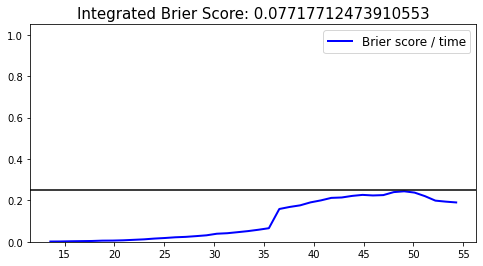

0.9163860894575253


In [ ]:
#dws.losses['State'][-2]
best_state = deepcopy(dws.losses['State'])
dws.model.load_state_dict(best_state)
print(np.min(dws.losses['Test']))

pi, beta, alpha, survival_predictions = dws.prdict_survival(X_test)
survival_predictions = np.squeeze(survival_predictions.data.numpy())

brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train, X_test.values, T_test, E_test, survival_predictions.T, plot=True)
figure.show()
mlt, c_index = dws.c_index(pi, alpha, beta, T_test, E_test)
print(c_index)

In [ ]:
pi

tensor([[9.9930e-01, 7.0086e-04],
        [9.9914e-01, 8.6380e-04],
        [9.9912e-01, 8.7895e-04],
        ...,
        [9.9927e-01, 7.2765e-04],
        [9.9943e-01, 5.7171e-04],
        [9.9961e-01, 3.8860e-04]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)

In [ ]:
pi[:,0].max()

tensor(0.0007, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [ ]:
data_test.loc[(data_test[event_column]==1) & (data_test[time_column]>=24) & (data_test[time_column]<=27)].index.values

array([ 310,  357,  466,  480,  507,  527,  609,  927, 1093, 1235, 1262,
       1311, 1690, 1982, 2010, 2074, 2089, 2237, 2270, 2319, 2441, 2540,
       2658, 2795, 2875])

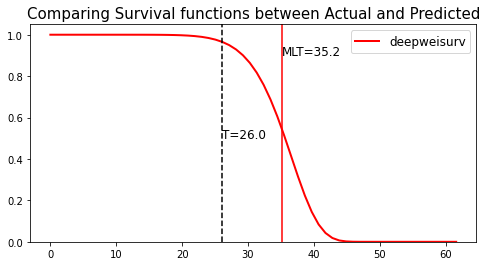

In [ ]:
k = 2089
t = T_test[k]
l_predicted = survival_predictions[:,k]
#cox_pred = cox_surv.iloc[:, k].values.flatten()
#gomp_predicted = gomp_survival[k].flatten()
#custome_lmt = survival[k].flatten()
''' = lmtlr.predict_survival(X_test.iloc[[k]].values).flatten()
nmtlr_predicted = n_mtlr.predict_survival(X_test.iloc[[k]].values).flatten()'''

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(dws.times, l_predicted.flatten(), color='red', label='deepweisurv', lw=2)
#plt.plot(cox_surv.index, cox_pred, color='blue', label='deephit', lw=2)
'''plt.plot(lmtlr.times, pys_predicted, color='blue', label='pysurvival', lw=2)
plt.plot(n_mtlr.times, nmtlr_predicted, color='green', label='pysurvival nmtlr', lw=2)'''
#plt.plot(gomp_model.times, gomp_predicted, color='green', label='gompertz', lw=2)
#plt.plot(l_mtlr.times, custome_lmt, color='black', label='custome mt', lw=2)


plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=12)
plt.axvline(x=mlt[k], color='red', ls ='-')
ax.annotate('MLT={:.1f}'.format(mlt[k]), xy=(mlt[k], 0.5), xytext=(mlt[k], 0.9), fontsize=12)
# Show everything
title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t.
#Survival Function defines the probability that the event of interest has not occurred at time t 

In [ ]:
from google.colab import files
times = pd.DataFrame(dws.times)
times.to_csv('times.csv')
files.download('times.csv')

surv = pd.DataFrame(survival_predictions.T)
surv.to_csv('creditcard_surv_pred.csv')
files.download('creditcard_surv_pred.csv')

data_test['MLT'] = mlt
data_test.to_csv('data_test.csv')
files.download('data_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
churned = np.where(E_test)[0]
np.abs(T_test.iloc[churned] - mlt[churned])

0        1.184945
5        7.663651
6        3.134275
10       0.752168
11       4.098729
          ...    
3013    14.483913
3014     8.926565
3017     4.024255
3033     3.853731
3038    18.688829
Name: Months_on_book, Length: 488, dtype: float64

In [ ]:
data_test

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,1,40,3,34.00001,1,3,4,29715.0,0,0.399,2128,39,0.345,0.000,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,0,37,1,19.00001,6,1,2,18951.0,1243,1.148,2874,58,0.657,0.066,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0
2,0,41,3,31.00001,3,3,2,1438.3,913,0.981,4300,68,0.619,0.635,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3,0,47,3,36.00001,3,2,1,2500.0,1169,0.638,4265,87,0.812,0.468,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,0,35,1,29.00001,4,3,3,1438.3,966,0.871,5249,81,0.761,0.672,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3034,0,40,3,31.00001,4,2,3,27374.0,1509,0.803,4231,60,0.714,0.055,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3035,0,47,3,41.00001,4,3,3,3788.0,1540,0.566,1594,47,0.382,0.407,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3036,0,44,1,36.00001,3,3,3,2568.0,1603,0.432,3616,85,0.545,0.624,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3037,0,51,2,38.00001,4,1,2,9648.0,1926,0.549,1083,22,1.750,0.200,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['title']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


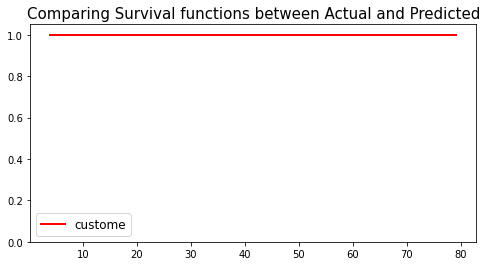

In [ ]:
from torch.distributions.log_normal import LogNormal
import torch
import numpy as np
from matplotlib import pyplot as plt
%pylab inline

d = LogNormal(-1, -0.2, validate_args=None)
t = np.linspace(4,79.2,80)
surv = 1 - d.cdf(torch.FloatTensor(t))

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(t, surv.data.numpy().flatten(), color='red', label='custome', lw=2)


# Show everything
title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t.
#Survival Function defines the probability that the event of interest has not occurred at time t 